<a href="https://colab.research.google.com/github/claudwq/gan/blob/master/GAN_MNIST_With_SEED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas, numpy, random
import matplotlib.pyplot as plt 

In [3]:
class MnistDataset(Dataset):
  def __init__(self,csv_file):
    self.data_df=pandas.read_csv(csv_file, header=None)
    pass
  def __len__(self):
    return len(self.data_df)
  def __getitem__(self,index):
    label=self.data_df.iloc[index,0]
    target = torch.zeros((10))
    target[label]=1.0

    #image data, nomaliszed form 0-255 to 0-1
    image_values=torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0

    return label,image_values,target

    
  def plot_image(self, index):
    img =self.data_df.iloc[index,1:].values.reshape(28,28)
    plt.title('label='+str(self.data_df.iloc[index,0]))
    plt.imshow(img,interpolation='none',cmap='Blues')
    pass
  pass

In [4]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/mnist_data/mnist_train.csv')

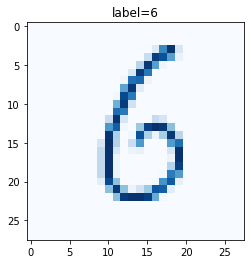

In [5]:
mnist_dataset.plot_image(18)

In [6]:
#functions to generate random data
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [8]:
#discriminator class
class Discriminator(nn.Module):
  def __init__(self):
    #initalise parent pytorch class
    super().__init__()

    #define nn layers

    self.model = nn.Sequential(
        nn.Linear(784,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200,1),
        nn.Sigmoid()
    )

    #create loss function
    self.loss_function = nn.BCELoss()

    #crate optimiser, simple stochastic gradient descent
    self.optimiser = torch.optim.Adam(self.parameters(),lr=0.0001)

    #counter and accumulator for progress
    self.counter = 0
    self.progress = []

    pass

  def forward(self,inputs):
    #simply run model
    return self.model(inputs)

  def train(self,inputs,targets):
    #calculate the output of the network
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    #increase the counter and accumulate error every q0
    self.counter+=1
    if(self.counter%10==0):
      self.progress.append(loss.item())
      pass
    if (self.counter%10000==0):
      print('counter=',self.counter)
      pass
    #zero gradinets, perform a backward pass, update weights

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress,columns=['loss'])
    df.plot(ylim=(0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5,1.0,5.0))
    pass

  pass

In [9]:
%%time
#test if discriminator can separate real data from random noise

D=Discriminator()
for label, image_data_tensor, target_tensor in mnist_dataset:
  #real data
  D.train(image_data_tensor,torch.FloatTensor([1.0]))
  #fake data
  D.train(generate_random_image(784),torch.FloatTensor([0.0]))
  pass

counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000
CPU times: user 3min 17s, sys: 3.27 s, total: 3min 20s
Wall time: 3min 20s


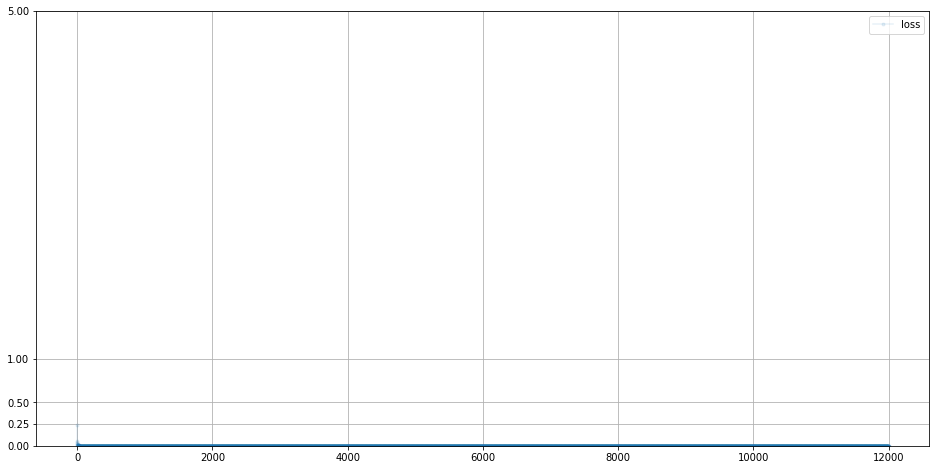

In [10]:
#plot discriminator loss
D.plot_progress()

In [11]:
#manually run discriminator to check it can tell real data from fake
for i in range(4):
  image_data_tensor=mnist_dataset[random.randint(0,60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image(784)).item())
  pass

1.0
1.0
1.0
1.0
9.220377933383261e-12
9.790642255258497e-12
8.870635996582887e-12
1.0039140525830437e-11


In [12]:
#generator class

class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    #define nn layer
    self.model=nn.Sequential(
        nn.Linear(100,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200,784),
        nn.Sigmoid()
    )

    #create optimiser, simple stochastic gradinet descent
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    #counter and accumulator for progress
    self.counter = 0
    self.progress = []
    pass

  def forward(self, inputs):
    #run the model
    return self.model(inputs)

  def train(self,  D, inputs, targets):
    #caculate the output of the network
    g_output=self.forward(inputs)
    #pass the output onto Discriminator for feedback
    d_output=D.forward(g_output)

    #caculate the error
    loss=D.loss_function(d_output, targets)

    #increase counter and accumulate error every 10
    self.counter+=1
    if(self.counter%10==0):
      self.progress.append(loss.item())
      pass

    #zero gradients, perform a backward pass, update weights
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df=pandas.DataFrame(self.progress,columns=['loss'])
    df.plot(ylim=(0),figsize=(16,8),alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5,1.0,5.0))
    pass

  pass


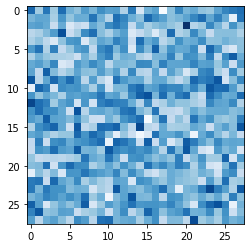

In [13]:
G=Generator()
output=G.forward(generate_random_seed(100))
img=output.detach().numpy().reshape(28,28)
plt.imshow(img,interpolation='none',cmap='Blues')

In [14]:
%%time
#create discriminator and generator
D=Discriminator()
G=Generator()
epochs=4
for epoch in range(epochs):
  print('epoch=',epoch+1)

  for label, image_data_tensor, target_tensor in mnist_dataset:
    #train D on true
    D.train(image_data_tensor,torch.FloatTensor([1.0]))
    #train D on flase
    #use detach(), so gradients in G not calculated
    D.train(G.forward(generate_random_seed(100)).detach(),torch.FloatTensor([0.0]))

    #train G
    G.train(D,generate_random_seed(100),torch.FloatTensor([1.0]))

    pass
  pass

epoch= 1
counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000
epoch= 2
counter= 130000
counter= 140000
counter= 150000
counter= 160000
counter= 170000
counter= 180000
counter= 190000
counter= 200000
counter= 210000
counter= 220000
counter= 230000
counter= 240000
epoch= 3
counter= 250000
counter= 260000
counter= 270000
counter= 280000
counter= 290000
counter= 300000
counter= 310000
counter= 320000
counter= 330000
counter= 340000
counter= 350000
counter= 360000
epoch= 4
counter= 370000
counter= 380000
counter= 390000
counter= 400000
counter= 410000
counter= 420000
counter= 430000
counter= 440000
counter= 450000
counter= 460000
counter= 470000
counter= 480000
CPU times: user 22min 9s, sys: 21.9 s, total: 22min 31s
Wall time: 22min 29s


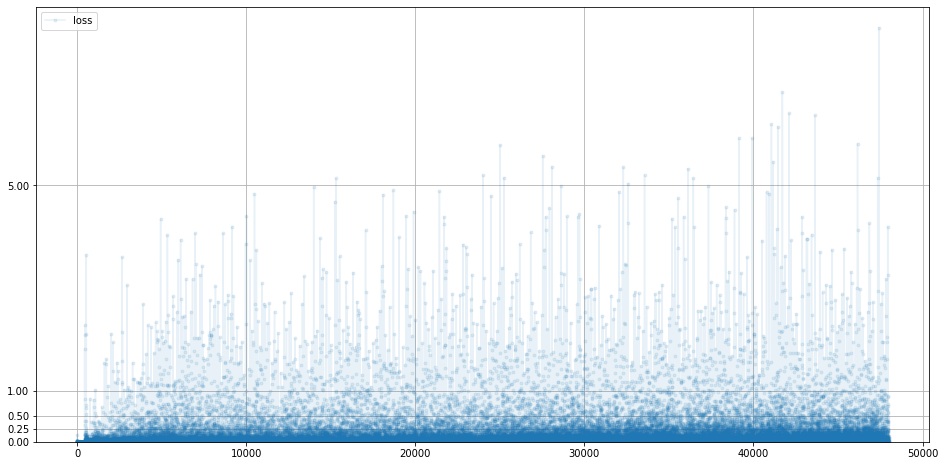

In [15]:
D.plot_progress()

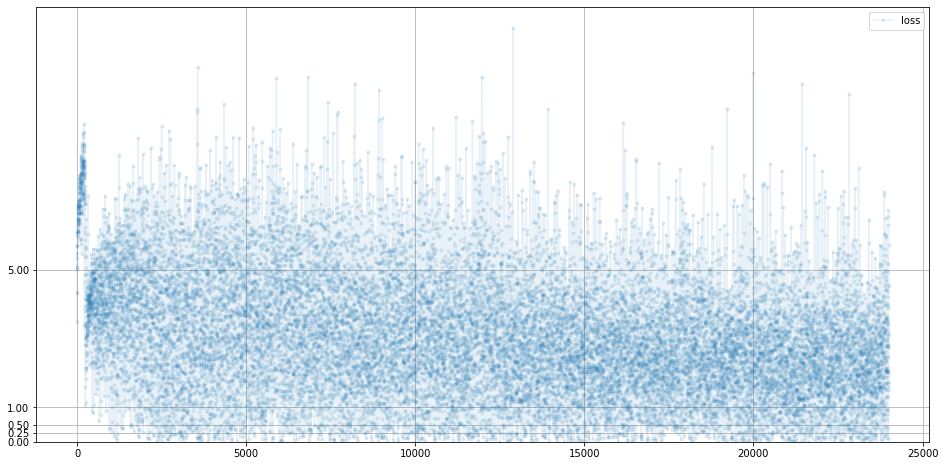

In [16]:
G.plot_progress()

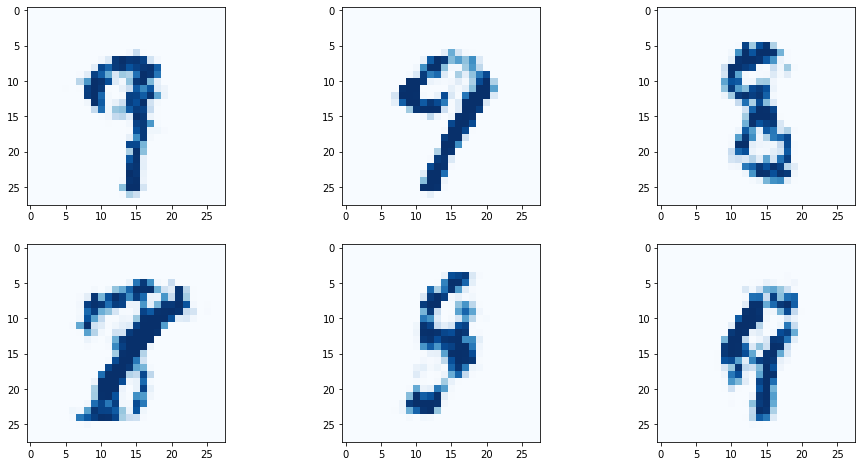

In [17]:
#plot several outputs from the trained generator
#plot a 3 colum, 2 row array of generated images
f,axarr=plt.subplots(2,3,figsize=(16,8))
for i in range(2):
  for j in range(3):
    output=G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img,interpolation='none',cmap='Blues')
    pass
  pass

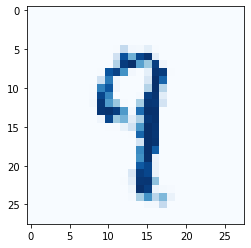

In [18]:
seed1=generate_random_seed(100)
out1=G.forward(seed1)
img1=out1.detach().numpy().reshape(28,28)
plt.imshow(img1,interpolation='none',cmap='Blues')

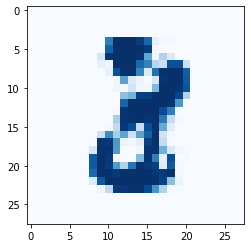

In [19]:
seed2=generate_random_seed(100)
out2=G.forward(seed2)
img2=out2.detach().numpy().reshape(28,28)
plt.imshow(img2,interpolation='none',cmap='Blues')

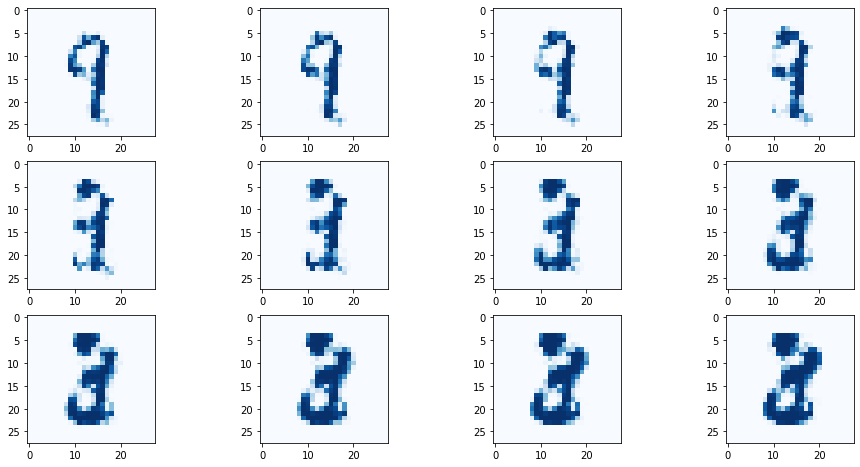

In [21]:
count = 0
f,axarr=plt.subplots(3,4,figsize=(16,8))
for i in range(3):
  for j in range(4):
    seed=seed1+(seed2-seed1)/11*count
    output = G.forward(seed)
    img=output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img,interpolation='none',cmap='Blues')
    count=count+1
    pass
  pass

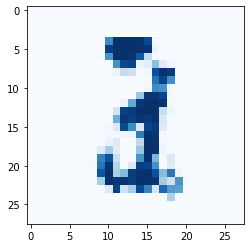

In [22]:
seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

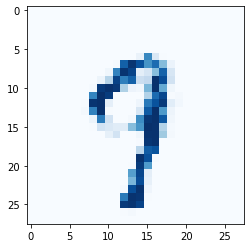

In [23]:
seed4 = seed1 -seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

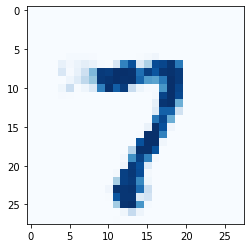

In [24]:
seed5 = seed1 * seed2
out5 = G.forward(seed5)
img5 = out5.detach().numpy().reshape(28,28)
plt.imshow(img5, interpolation='none', cmap='Blues')